# Access data from ASReview file

<div class="alert alert-warning">

The API is still under development and can change at any time without warning. 

</div>

Data generated using ASReview LAB is stored in an ASReview project file. Via the ASReview Python API, there are two ways to access the data in the ASReview (extension `.asreview`) file: Via the [asreview.Project](reference/asreview.rst#asreview.Project) API and the [asreview.SQLiteState](reference/asreview.rst#asreview.SQLiteState) API. The project API is for retrieving general project settings, the imported dataset, the feature matrix, etc. The state API retrieves data related directly to the reviewing process, such as the labels, the time of labeling, and the classifier used. 




## Example Data
To illustrate the ASReview Python API, the benchmark dataset `van_de_Schoot_2017` is used.  The project file `example.asreview` can be obtained by running ```asreview simulate benchmark:van_de_Schoot_2017 -o example.asreview --seed 101```. 

The ASReview Python API can be used for project files obtained via the Oracle, Validation, and Simulation mode. 

## Python Imports

In [ ]:
import shutil
from pathlib import Path

import pandas as pd

import asreview as asr

## Project API
The ASReview project file is a zipped folder. To unzip the folder and store its contents in a temporary directory, use the following code: 

In [ ]:
project_path = Path("tmp_data")
project_path.mkdir()
project = asr.Project.load("example.asreview", project_path)

The returned instance is of type [asreview.Project](reference/asreview.rst#asreview.Project).

To inspect the project details, use the following code:

In [ ]:
project.config

{'version': '1.2+6.g41c4257.dirty',
 'id': 'example',
 'mode': 'simulate',
 'name': 'example',
 'description': 'Simulation created via ASReview via command line interface',
 'authors': None,
 'created_at_unix': 1683798551,
 'datetimeCreated': '2023-05-11 11:49:11.327073',
 'reviews': [{'id': 'e611d2cbd89b401aa376fa4eca1c517e',
   'start_time': '2023-05-11 11:49:12.323797',
   'status': 'finished',
   'end_time': '2023-05-11 11:49:32.450593'}],
 'feature_matrices': [{'id': 'tfidf', 'filename': 'tfidf_feature_matrix.npz'}],
 'dataset_path': 'van_de_Schoot_2017.csv'}

The imported dataset is located at `/tmp_data/{project_name}/data/{dataset_filename}`, and can be inspected using the following code: 

In [ ]:
dataset_fp = Path(
    project_path, project.config["id"], "data", project.config["dataset_path"]
)
dataset = asr.Dataset.from_file(dataset_fp)
print(f"The dataset contains {len(dataset)} records.")
dataset.to_dataframe().head()

The dataset contains 6189 records.


,title,abstract,keywords,authors,year,date,doi,label_included,label_abstract_screening,duplicate_record_id
record_id,,,,,,,,,,
0,Manual for ASEBA School-Age Forms & Profiles,,,"Achenbach, T. M., Rescorla, L. A.",2001.0,2001,NaN,0,0,NaN
1,Queensland Trauma Registry: A summary of paedi...,,,"Dallow, N., Lang, J., Bellamy, N.",2007.0,2007,NaN,0,0,NaN
2,Posttraumatic Stress Disorder: Scientific and ...,This comprehensive overview of research and cl...,,"Ford, J. D., Grasso, D. J., Elhai, J. D., Cour...",2015.0,NaN,NaN,0,0,NaN
3,SOCIAL CLASS AND MENTAL ILLNESS,,,"Hollingshead, A. B., Redlich, F. C.",1958.0,NaN,NaN,0,0,NaN
4,Computerised test generation for cross-nationa...,“‘Computerised Test Generation for Cross-Natio...,,"Irvine, S. H.",2014.0,NaN,NaN,0,0,NaN


To obtain the content of the feature matrix, for example, the first row of the matrix, use the following code (note the matrix is in a sparse matrix format):

In [5]:
feature_extractor_id = project.feature_matrices[0]["id"]
feature_model = asr.load_extension("models.feature_extractors", feature_extractor_id)
feature_matrix = project.get_feature_matrix(feature_model.name)
print(feature_matrix[0])

  (0, 20452)	0.35937211648312967
  (0, 18297)	0.26158369118434677
  (0, 13842)	0.3248271421716685
  (0, 9739)	0.38355660008860293
  (0, 3231)	0.7059309068495663
  (0, 2384)	0.22684547910949254


## State API

The data stored during the review process can be accessed as a pandas DataFrame using the following code:

In [6]:
with asr.open_state("example.asreview") as state:
    df = state.get_dataset()
    print(f"The state contains {len(df)} records.")

The state contains 561 records.


The returned `state` instance is of type [asreview.SQLState](reference/asreview.rst#asreview.SQLiteState). Note that the state contains less records than the original dataset. This is because by default the simulation stops after finding all relevant records.

In [7]:
df.to_csv(project_path / "example_state.csv", index=False)
df.head()

,record_id,label,classifier,querier,balancer,feature_extractor,training_set,labeling_time,notes
0,4435,1,None,prior,None,None,-1,2023-05-11 11:49:16.186034,None
1,5560,0,None,prior,None,None,-1,2023-05-11 11:49:16.186034,None
2,4434,1,nb,max,double,tfidf,2,2023-05-11 11:49:16.420695,None
3,3668,0,nb,max,double,tfidf,3,2023-05-11 11:49:16.444989,None
4,3142,0,nb,max,double,tfidf,4,2023-05-11 11:49:16.505603,None


You can merge the information from the state file with the original dataset.

In [8]:
df["labeling_order"] = df.index
dataset_with_results = dataset.df.join(df.set_index("record_id"))
dataset_with_results.to_csv(project_path / "data_and_state_merged.csv", index=False)
dataset_with_results

,title,abstract,keywords,authors,year,date,doi,label_included,label_abstract_screening,duplicate_record_id,label,classifier,querier,balancer,feature_extractor,training_set,labeling_time,notes,labeling_order
record_id,,,,,,,,,,,,,,,,,,,
0,Manual for ASEBA School-Age Forms & Profiles,,,"Achenbach, T. M., Rescorla, L. A.",2001.0,2001,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Queensland Trauma Registry: A summary of paedi...,,,"Dallow, N., Lang, J., Bellamy, N.",2007.0,2007,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Posttraumatic Stress Disorder: Scientific and ...,This comprehensive overview of research and cl...,,"Ford, J. D., Grasso, D. J., Elhai, J. D., Cour...",2015.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SOCIAL CLASS AND MENTAL ILLNESS,,,"Hollingshead, A. B., Redlich, F. C.",1958.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Computerised test generation for cross-nationa...,“‘Computerised Test Generation for Cross-Natio...,,"Irvine, S. H.",2014.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6184,Biological and clinical framework for posttrau...,Three decades of posttraumatic stress disorder...,,"Vermetten, E., Lanius, R. A.",2012.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6185,Dividing traffic sub-areas based on a parallel...,In order to alleviate the traffic congestion a...,"GPS trajectories, K-means, MapReduce, Traffic ...","Wang, B., Tao, L., Gao, C., Xia, D., Rong, Z.,...",2014.0,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6186,Quantifying resilience to enhance individualiz...,Resilience is the human ability to adapt in th...,"Adaptation, Autonomic Nervous System, Resilien...","Winslow, B., Carroll, M., Jones, D., Hannigan,...",2013.0,NaN,NaN,0,0,NaN,0.0,nb,max,double,tfidf,535.0,2023-05-11 11:49:31.593247,None,535.0


There are also multiple functions to obtain one specific variable in the data. For example, to plot the labeling times in a graph, use the following code: 

<Axes: title={'center': 'Time of labeling'}>

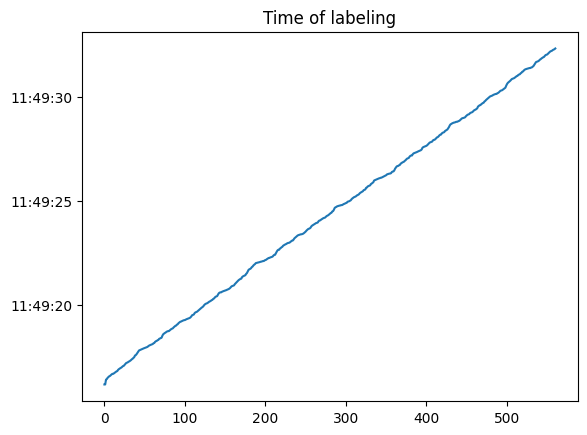

In [9]:
with asr.open_state("example.asreview") as state:
    labeling_times = state.get_labeling_times()
pd.to_datetime(labeling_times).plot(title="Time of labeling")

By default, the records that are part of the prior knowledge are included in the results. To obtain the labels use the following code:

In [10]:
with asr.open_state("example.asreview") as state:
    labels = state.get_labels(priors=False)
labels

0      1
1      0
2      0
3      0
4      0
      ..
554    0
555    0
556    0
557    0
558    1
Name: label, Length: 559, dtype: int64

To obtain the data corresponding to a specific record identifier, use the following code:

In [11]:
with asr.open_state("example.asreview") as state:
    record_data = state.get_data_by_record_id(5176)
record_data

,record_id,label,classifier,querier,balancer,feature_extractor,training_set,labeling_time,notes
0,5176,0,nb,max,double,tfidf,29,2023-05-11 11:49:17.247842,None


To obtain all settings used for the project, run the following code:

In [12]:
with asr.open_state("example.asreview") as state:
    settings = state.settings_metadata
settings

{'settings': {'model': 'nb',
  'querier': 'max',
  'balancer': 'double',
  'feature_extractor': 'tfidf',
  'n_query': 1,
  'n_stop': 'min',
  'n_prior_included': 1,
  'n_prior_excluded': 1,
  'model_param': {'alpha': 3.822},
  'querier_param': {},
  'feature_extractor_param': {'ngram_max': 1,
   'stop_words': 'english',
   'split_ta': 0,
   'use_keywords': 0},
  'balancer_param': {'a': 2.155, 'alpha': 0.94, 'b': 0.789, 'beta': 1.0}},
 'state_version': '1',
 'software_version': '1.2+6.g41c4257.dirty',
 'model_has_trained': True}

The state also contains the ranking and the relevance score (if the model uses relevance scores) of the last iteration of the machine learning model. To get these, use the following code:

In [13]:
with asr.open_state("example.asreview") as state:
    last_ranking = state.get_last_ranking()
    last_probabilities = state.get_last_probabilities()
print("RANKING:")
print(last_ranking[["record_id", "ranking"]])
print("RELEVANCE SCORES:")
print(last_probabilities)

RANKING:
      record_id  ranking
0          2445        0
1          2446        1
2          2444        2
3           720        3
4           719        4
...         ...      ...
6184       1766     6184
6185         63     6185
6186       4427     6186
6187       2851     6187
6188       4888     6188

[6189 rows x 2 columns]
RELEVANCE SCORES:
0       0.637417
1       0.671088
2       0.707728
3       0.777025
4       0.672183
          ...   
6184    0.792209
6185    0.697030
6186    0.828880
6187    0.768638
6188    0.844882
Name: proba, Length: 6189, dtype: float64


## Cleanup
The following code removes the temporary folder that was created:

In [14]:
shutil.rmtree(project_path)